In [ ]:
from pathlib import Path
import pandas as pd

In [ ]:
from collections import OrderedDict
from pprint import pprint
import json

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
root_dir = Path('~/data/rl-attention/full-scale').expanduser()

In [ ]:
def load_experiment(experiment_path: Path):
    logs = []

    for i in range(8):
        log_env_path = (experiment_path / 'logs' / f'{i}.monitor.csv')
        if not log_env_path.exists():
            print(f'{log_env_path} does not exist')
            continue
        log_env = pd.read_csv(log_env_path, skiprows=1).rename({
            'r': 'reward',
            'l': 'length',
            't': 'elapsed_time',
        }, axis=1)
        log_env['cumlength'] = log_env['length'].cumsum()
        log_env['env_index'] = i
        logs.append(log_env)

    log = pd.concat(logs).sort_values('elapsed_time')
    log.index.name = 'episode_index'
    log.reset_index(inplace=True)
    return log

log = load_experiment(root_dir / 'MsPacmanNoFrameskip-v4,0,0.0,2019-06-13_18-50-37.845')
log.head(n=10)

,episode_index,reward,length,elapsed_time,cumlength,env_index
0,0,200.0,412,15.045109,412,3
1,0,150.0,431,15.323186,431,2
2,0,140.0,445,15.460753,445,4
3,0,260.0,450,15.657383,450,5
4,0,200.0,458,15.742611,458,6
5,0,250.0,475,15.938758,475,1
6,0,640.0,674,19.786504,674,0
7,0,600.0,678,19.829119,678,7
8,1,150.0,393,21.944906,805,3
9,1,190.0,416,22.586305,861,4


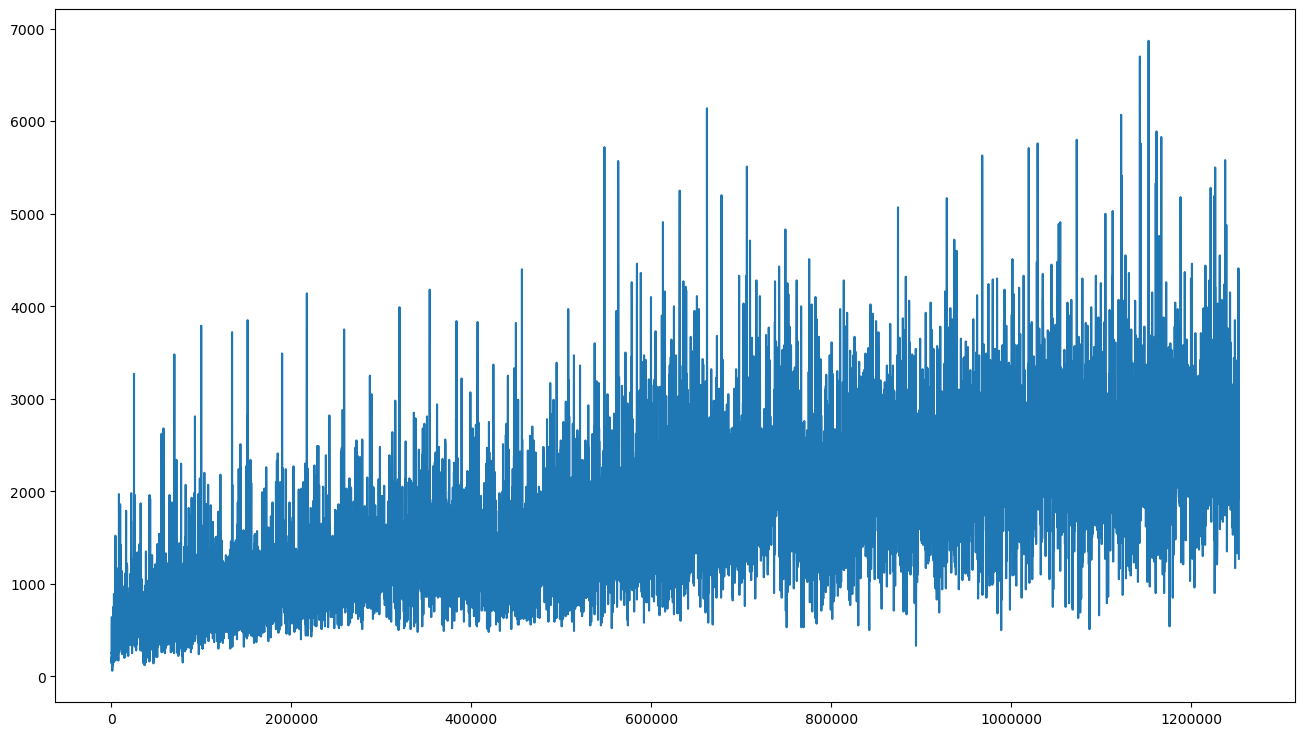

In [ ]:
plt.plot(log.cumlength, log.reward)

In [ ]:
experiment_records = []

for experiment_path in root_dir.iterdir():
    with (experiment_path / 'config.json').open() as fp:
        cfg = json.load(fp)
    row = OrderedDict([
        (key, cfg[key])
        for key in [
            'time_steps',
            'env_name',
            'attn_coef',
            'train_seed',
        ]
    ])
    assert row['env_name'].endswith('NoFrameskip-v4')
    row['game'] = row['env_name'][:-len('NoFrameskip-v4')]
    row['name'] = experiment_path.name
    row['timestamp'] = pd.to_datetime(row['name'].split(',')[-1], format='%Y-%m-%d_%H-%M-%S.%f')
#     row['missing_envs'] = [
#         i for i in range(8)
#         if not (root_dir / row['name'] / 'logs' / f'{i}.monitor.csv').exists()
#     ]
    experiment_records.append(row)

df = pd.DataFrame.from_records(experiment_records).sort_values(
    ['time_steps', 'env_name', 'attn_coef', 'train_seed']
).reset_index(drop=True)
df.head(n=10)

,time_steps,env_name,attn_coef,train_seed,game,name,timestamp
0,10000000,BeamRiderNoFrameskip-v4,0.0000,0,BeamRider,"BeamRiderNoFrameskip-v4,0,0.0,2019-06-13_18-50...",2019-06-13 18:50:37.871
1,10000000,BeamRiderNoFrameskip-v4,0.0000,1,BeamRider,"BeamRiderNoFrameskip-v4,1,0.0,2019-06-15_06-11...",2019-06-15 06:11:18.092
2,10000000,BeamRiderNoFrameskip-v4,0.0000,2,BeamRider,"BeamRiderNoFrameskip-v4,2,0.0,2019-06-16_23-48...",2019-06-16 23:48:05.212
3,10000000,BeamRiderNoFrameskip-v4,0.0000,3,BeamRider,"BeamRiderNoFrameskip-v4,3,0.0,2019-06-23_20-00...",2019-06-23 20:00:56.530
4,10000000,BeamRiderNoFrameskip-v4,0.0000,4,BeamRider,"BeamRiderNoFrameskip-v4,4,0.0,2019-06-25_15-45...",2019-06-25 15:45:36.893
5,10000000,BeamRiderNoFrameskip-v4,0.0005,0,BeamRider,"BeamRiderNoFrameskip-v4,0,0.0005,2019-06-14_00...",2019-06-14 00:49:23.711
6,10000000,BeamRiderNoFrameskip-v4,0.0005,1,BeamRider,"BeamRiderNoFrameskip-v4,1,0.0005,2019-06-15_12...",2019-06-15 12:09:02.842
7,10000000,BeamRiderNoFrameskip-v4,0.0005,2,BeamRider,"BeamRiderNoFrameskip-v4,2,0.0005,2019-06-17_03...",2019-06-17 03:29:15.848
8,10000000,BeamRiderNoFrameskip-v4,0.0005,3,BeamRider,"BeamRiderNoFrameskip-v4,3,0.0005,2019-06-24_02...",2019-06-24 02:06:11.701
9,10000000,BeamRiderNoFrameskip-v4,0.0005,4,BeamRider,"BeamRiderNoFrameskip-v4,4,0.0005,2019-06-25_21...",2019-06-25 21:58:01.687


In [ ]:
df.pivot_table(
    index='attn_coef',
    columns='game',
    values='train_seed',
    aggfunc=len,
)

game,BeamRider,Breakout,Enduro,Frostbite,MsPacman,Seaquest
attn_coef,,,,,,
0.0000,5,5,5,5,5,5
0.0005,5,5,5,5,5,5
0.0010,5,5,5,5,5,5
0.0020,5,5,5,5,5,5
0.0030,5,5,5,5,5,5
0.0050,5,5,5,5,5,5


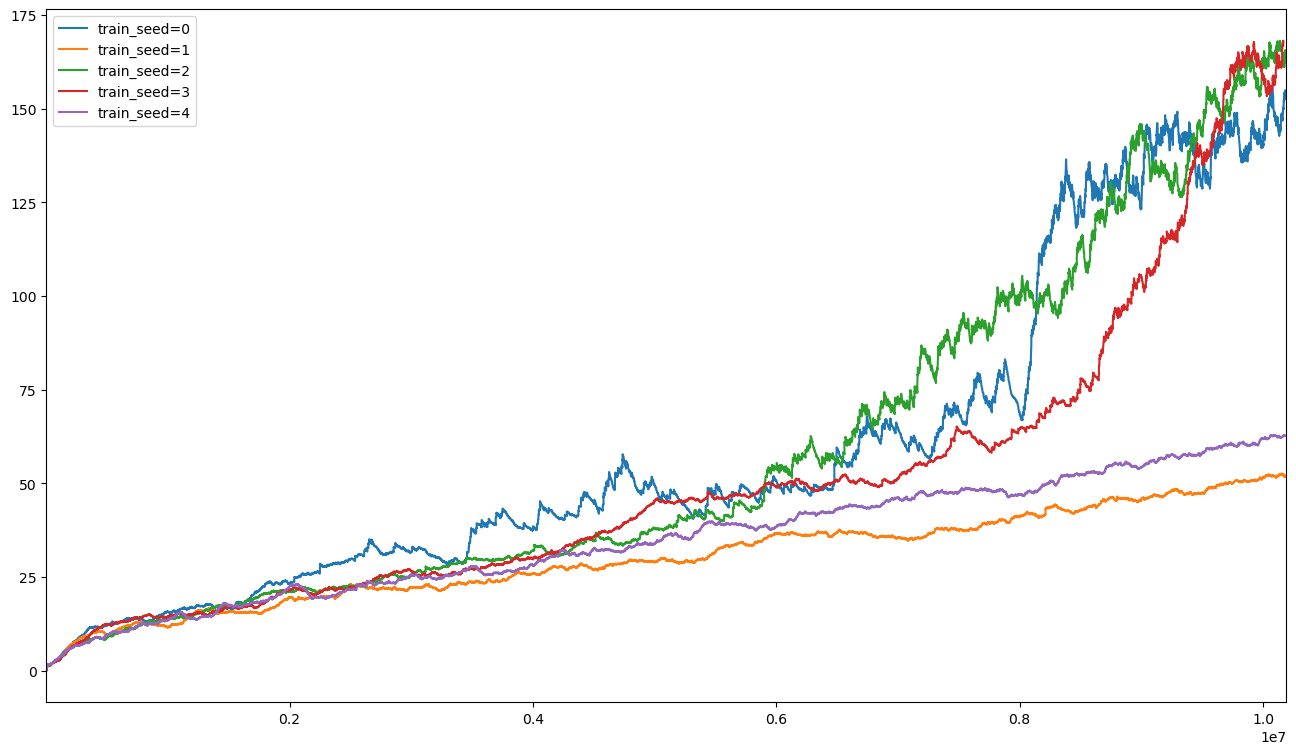

In [ ]:
for row in df[(df.game == 'Breakout') & (df.attn_coef == 0.0005)].itertuples():
    log = load_experiment(root_dir / row.name)
#     plt.plot(log.cumlength * 8, log.reward, label=f'train_seed={row.train_seed}')
    pd.Series(log.reward.values, index=(log.cumlength * 8).values).ewm(span=300).mean().plot(
        label=f'train_seed={row.train_seed}'
    )
    
    
plt.legend()

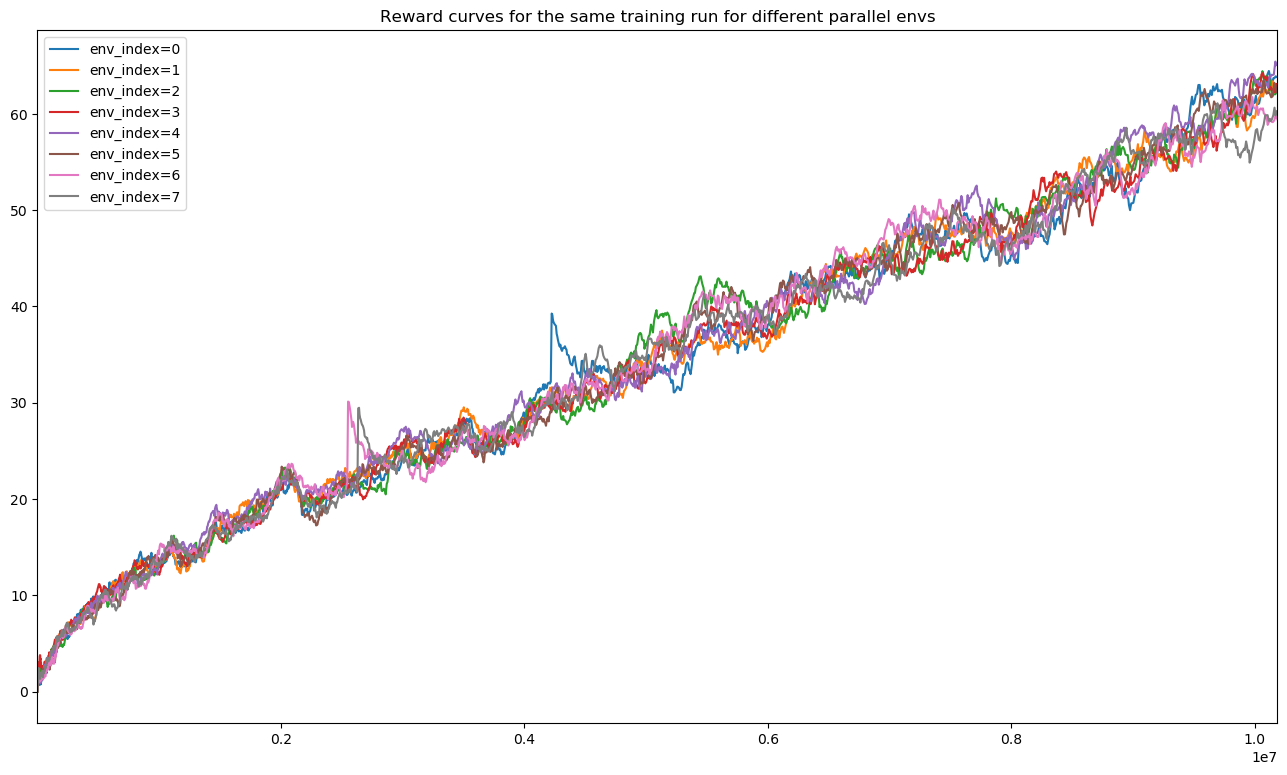

In [ ]:
for i, glog in log.groupby('env_index'):
    pd.Series(glog.reward.values, index=(glog.cumlength * 8).values).ewm(span=50).mean().plot(
        label=f'env_index={i}'
    )

plt.title('Reward curves for the same training run for different parallel envs')
plt.legend()

---

In [ ]:
import bisect

import numpy as np
import scipy as sp
import scipy.interpolate


def interpolate_series(sr, new_index):
    assert len(sr.values.shape) == 1
    assert len(new_index.shape) == 1
#     assert new_index[-1] <= sr.index[-1] < new_index[-1] + (new_index[-1] - new_index[-2])
    assert not sr.index.duplicated().any()
    
    spl = sp.interpolate.splrep(
        y=sr.values,
        x=sr.index,
        s=0,
        k=1,
    )
    new_values = sp.interpolate.splev(new_index, spl)
    
    return pd.Series(new_values, index=new_index)


def plot_averaged_curve(ax, srs, color, label=None, itrp_len=500):
    new_index_min = max(sr.index[0] for sr in srs)
    new_index_max = min(sr.index[-1] for sr in srs)
    new_index = np.linspace(new_index_min, new_index_max, itrp_len)
    itrp_srs = []
    for sr in srs:
#         itrp_index = new_index[:bisect.bisect_right(new_index, sr.index[-1])]
        isr = interpolate_series(sr, new_index)
        itrp_srs.append(isr)
    mean = []
    std = []
    for i in range(itrp_len):
        vals = [isr.iloc[i] for isr in itrp_srs if i < len(isr)]
        mean.append(np.mean(vals))
        std.append(np.std(vals))
    mean = np.array(mean)
    std = np.array(std)
    ax.plot(new_index, mean, color=color, alpha=0.7, label=label, lw=1)
    ax.fill_between(new_index, mean - std, mean + std, color=color, alpha=0.1, antialiased=True)
    return new_index, mean, std

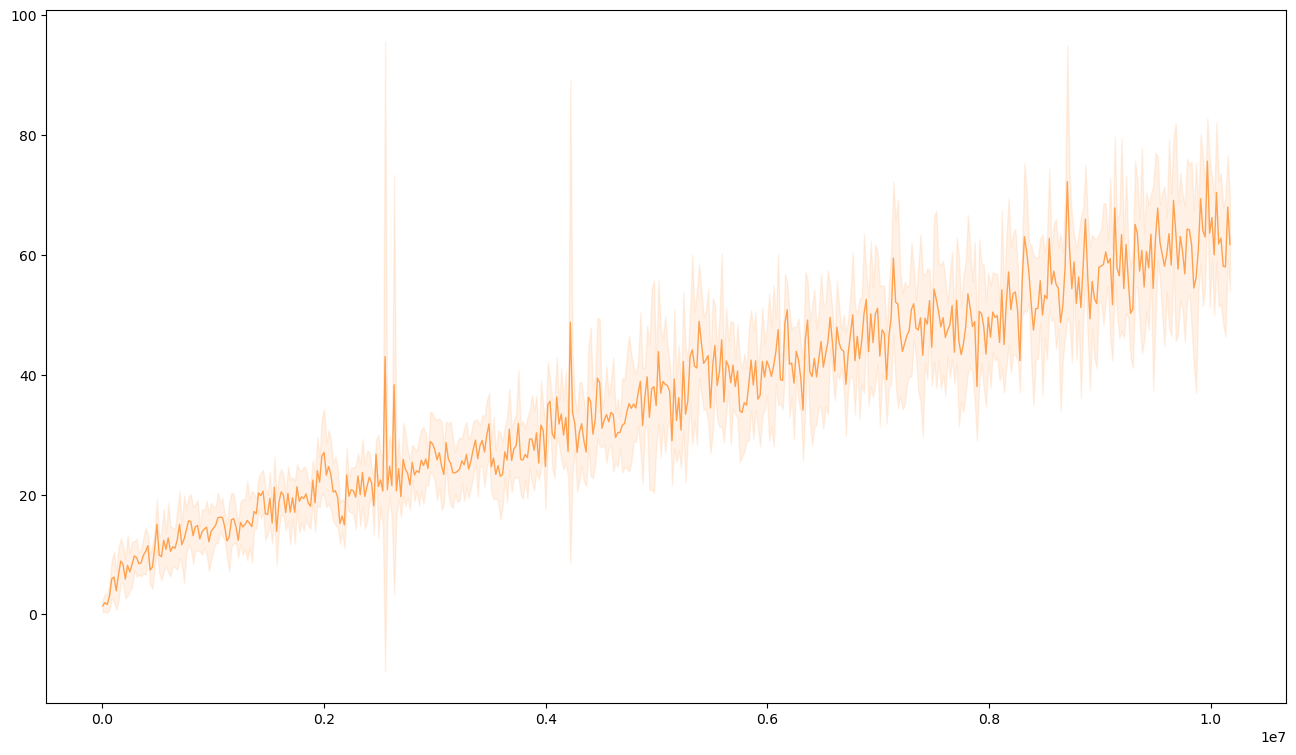

In [ ]:
_ = plot_averaged_curve(plt.gca(), [
    pd.Series(glog.reward.values, index=(glog.cumlength * 8).values)
    for i, glog in log.groupby('env_index')
], 'C1')

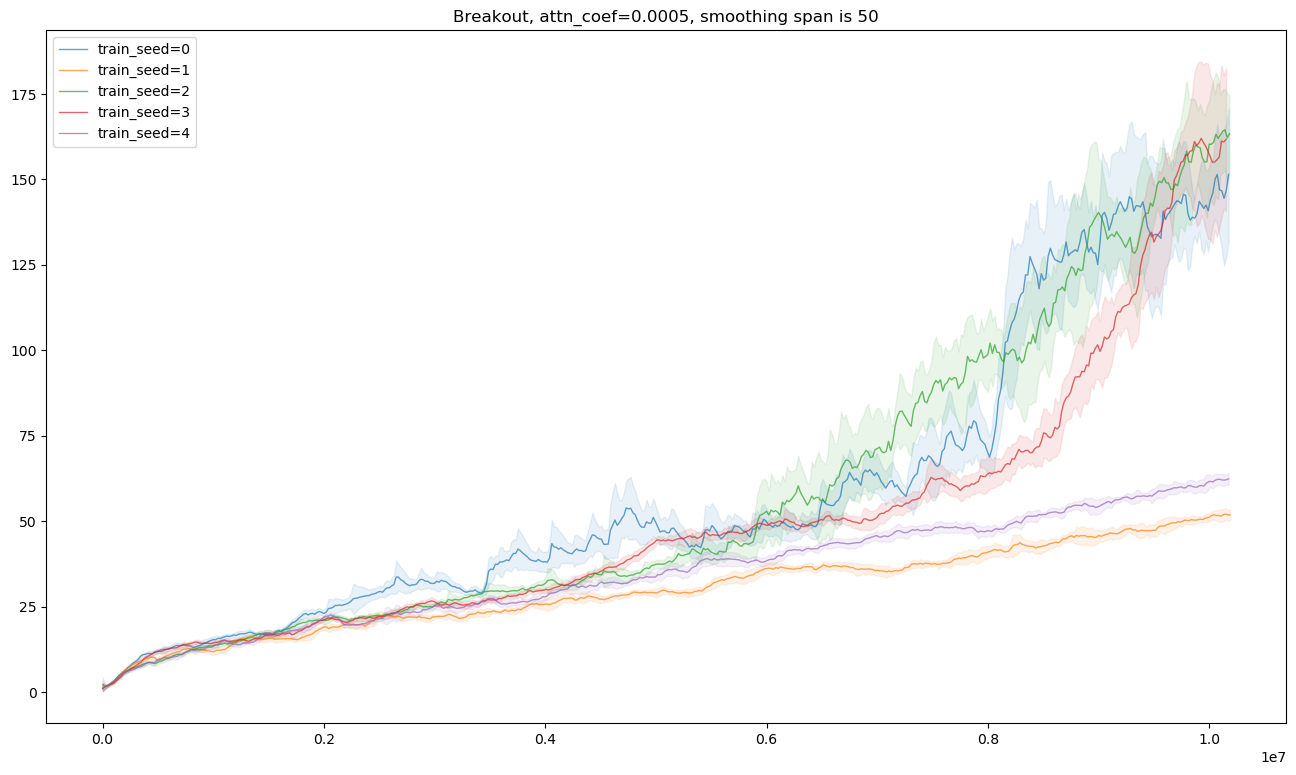

In [ ]:
for row in df[(df.game == 'Breakout') & (df.attn_coef == 0.0005)].itertuples():
    log = load_experiment(root_dir / row.name)
#     plt.plot(log.cumlength * 8, log.reward, label=f'train_seed={row.train_seed}')
#     pd.Series(log.reward.values, index=(log.cumlength * 8).values).ewm(span=300).mean().plot(
#         label=f'train_seed={row.train_seed}'
#     )
    plot_averaged_curve(plt.gca(), [
        pd.Series(glog.reward.values, index=(glog.cumlength * 8).values).ewm(span=50).mean()
        for i, glog in log.groupby('env_index')
    ], f'C{row.train_seed}', label=f'train_seed={row.train_seed}')
    
plt.title('Breakout, attn_coef=0.0005, smoothing span is 50')
plt.legend()

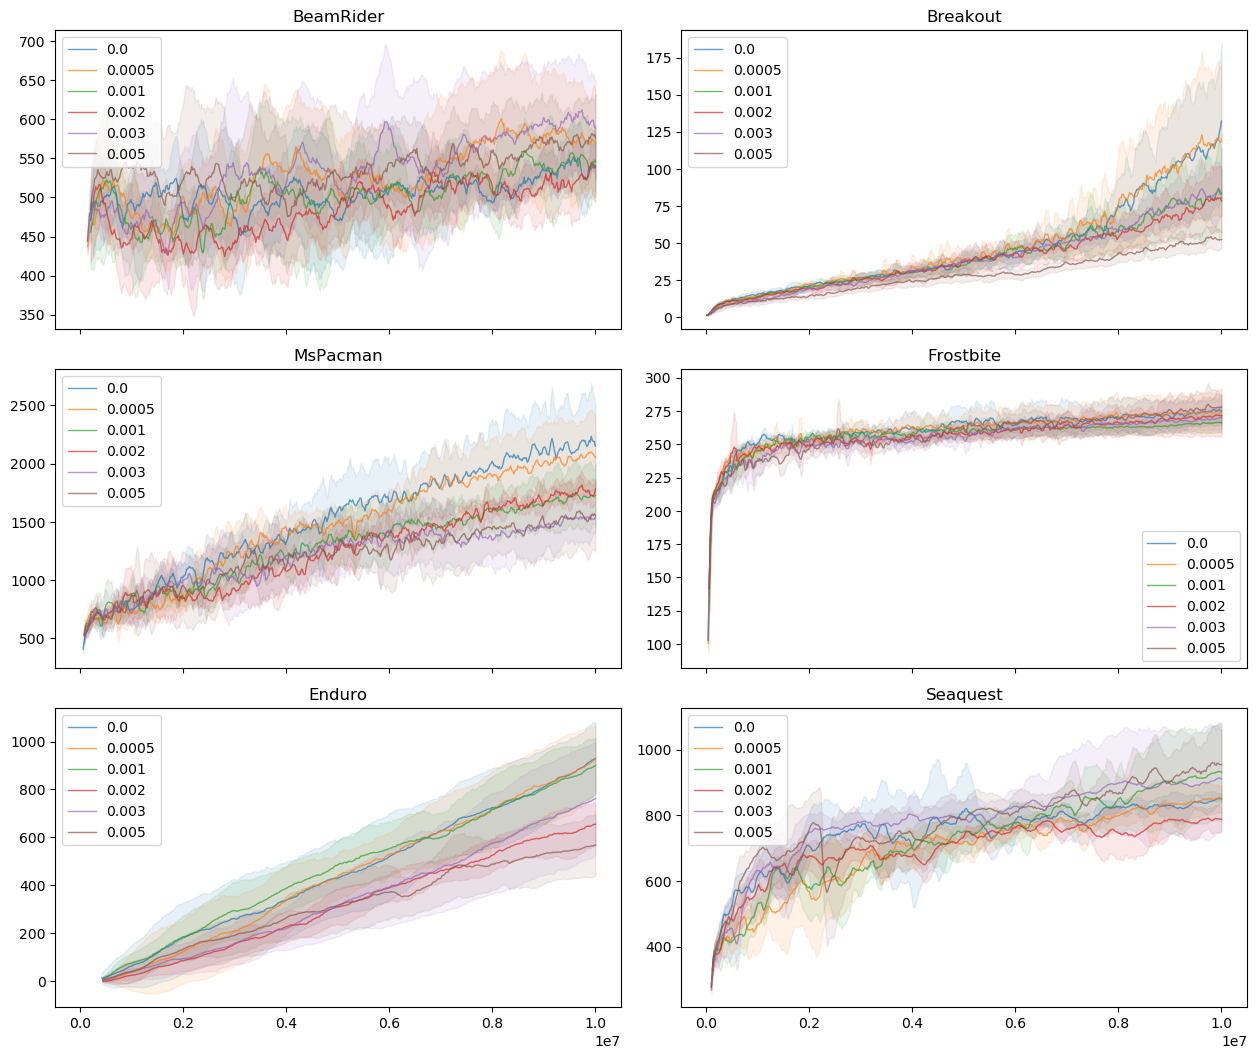

In [ ]:
from collections import OrderedDict

coef_colors = {
    coef: i
    for i, coef
    in enumerate(df.attn_coef.unique())
}

scale = 0.66
f, axarr = plt.subplots(nrows=3, ncols=2, figsize=(19.2 * scale, 16.2 * scale), sharex=True)

all_games = [
    'BeamRider', 'Breakout',
    'MsPacman', 'Frostbite',
    'Enduro', 'Seaquest',
]

records = []

for i, game in enumerate(all_games):
    ax = axarr[np.unravel_index(i, axarr.shape)]
    
    for attn_coef, ddf in df[df.game == game].groupby('attn_coef'):
        srs = []
        for row in ddf.itertuples():
            log = load_experiment(root_dir / row.name)
            sr = pd.Series(log.reward.values, index=(log.cumlength * 8).values)
            sr.index = sr.index / sr.index[-1] * 1e7
            sr = sr.groupby(sr.index).mean()
            sr = sr.rolling(100).mean()
            srs.append(sr)
        idx, mean, std = plot_averaged_curve(ax, srs, f'C{coef_colors[attn_coef]}', label=str(attn_coef))
        records.append(OrderedDict([
            ('game', game),
            ('attn_coef', attn_coef),
            ('mean', mean[-1]),
            ('std', std[-1]),
        ]))

    ax.set_title(game)
    ax.legend()

f.tight_layout()
f.savefig('/tmp/rl-attention/rl_attention_plots.pdf')

In [ ]:
df_results = pd.DataFrame.from_records(records)
df_results['mean_std'] = df_results.apply(lambda row: f'{row["mean"]:.0f}±{row["std"]:.0f}', axis=1)
df_results = df_results.pivot(
    index='attn_coef',
    columns='game',
    values='mean_std'
)
df_results.index.name = None
df_results.to_csv('/tmp/rl-attention/rl_attention_results.csv')
df_results

game,BeamRider,Breakout,Enduro,Frostbite,MsPacman,Seaquest
0.0000,540±30,132±52,929±153,275±9,2151±359,851±15
0.0005,569±69,120±52,926±143,273±15,2051±337,849±39
0.0010,546±43,83±30,899±116,266±7,1725±266,931±151
0.0020,538±43,78±21,655±87,271±15,1783±70,788±36
0.0030,589±62,84±15,762±235,270±9,1542±135,911±162
0.0050,576±55,52±6,569±129,278±14,1554±310,954±108
